In [0]:
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from gensim.models import Word2Vec

In [0]:
%cd /content/drive/My\ Drive/datasets/amazon_food_reviews/



/content/drive/My Drive/datasets/amazon_food_reviews


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading Data

In [0]:

# using SQLite Table to read data.
conn = sqlite3.connect('database.sqlite')

filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000", conn)

#print(filtered_data.columns)
#print(filtered_data.head(2))
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def rating(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(rating) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data :", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data : (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display_unique_users = pd.read_sql_query("""SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*) FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", conn)

In [0]:
print('Unique users:',display_unique_users.shape)
display_unique_users.head(4)

Unique users: (80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3


In [0]:
print('Total No. of Reviews:',display_unique_users['COUNT(*)'].sum())

Total No. of Reviews: 393063


# Exploratory Data Analysis

# Data Cleaning

In [0]:
display_duplicate_reviews= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", conn)
display_duplicate_reviews.head(6)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


It is observed (as shown in the table above) that the reviews data had many duplicate entries.
Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [0]:
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
print('final_data after removing duplicated row entries:',final_data.shape)

final_data after removing duplicated row entries: (87775, 10)


In [0]:
display_HelpfulnessNumerator_corrupted_reviews= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator 
ORDER BY ProductID
""", conn)
display_HelpfulnessNumerator_corrupted_reviews.head(6)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


HelpfulnessNumerator > HelpfulnessDenominator ,which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]
print('final_data after removing corrupted HelpfulnessNumerator:',final_data.shape)

final_data after removing corrupted HelpfulnessNumerator: (87773, 10)


In [0]:
final_data['Score'].value_counts()

1    73592
0    14181
Name: Score, dtype: int64

# PreProcessing review text

1.Begin by removing the html tags

2.Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)


In [0]:
text_0=final_data['Text'].values[0]
print(text_0)
print('_'*50)
text_100=final_data['Text'].values[100]
print(text_100)
print('_'*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
__________________________________________________
My Frenchbull is only given nylabone's to chew. He has had them since he was 7 weeks old. They are safe for him because he has a strong bite and they don't break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.
__________________________________________________


In [0]:
import re
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
text_0 = re.sub(r"http\S+", "", text_0)
text_100 = re.sub(r"http\S+", "", text_100)

print(text_0)
print('_'*50)
print(text_100)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
__________________________________________________
My Frenchbull is only given nylabone's to chew. He has had them since he was 7 weeks old. They are safe for him because he has a strong bite and they don't break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.


In [0]:
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(text_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(text_100, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
My Frenchbull is only given nylabone's to chew. He has had them since he was 7 weeks old. They are safe for him because he has a strong bite and they don't break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.


In [0]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

text_100 = decontracted(text_100)
print(text_100)
print("="*50)

My Frenchbull is only given nylabone is to chew. He has had them since he was 7 weeks old. They are safe for him because he has a strong bite and they do not break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
text_100 = re.sub("\S*\d\S*", "", text_100).strip()
print(text_100)

My Frenchbull is only given nylabone is to chew. He has had them since he was  weeks old. They are safe for him because he has a strong bite and they do not break off in large pieces that he could choke on. The Dinosaur Chew is perfect because it has so many places to hold and bite.  Dylabone is the only product I buy.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
text_100 = re.sub('[^A-Za-z0-9]+', ' ', text_100)
print(text_100)

My Frenchbull is only given nylabone is to chew He has had them since he was weeks old They are safe for him because he has a strong bite and they do not break off in large pieces that he could choke on The Dinosaur Chew is perfect because it has so many places to hold and bite Dylabone is the only product I buy 


In [0]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Pre processing all reviews
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for Text in tqdm(final_data['Text'].values):
    Text = re.sub(r"http\S+", "", Text)
    Text = BeautifulSoup(Text, 'lxml').get_text()
    Text = decontracted(Text)
    Text = re.sub("\S*\d\S*", "", Text).strip()
    Text = re.sub('[^A-Za-z]+', ' ', Text)
    # https://gist.github.com/sebleier/554280
    Text = ' '.join(e.lower() for e in Text.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(Text.strip())

100%|██████████| 87773/87773 [00:37<00:00, 2337.89it/s]


In [0]:
warnings.filterwarnings("ignore")
# Pre processing all review summary
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for Text in tqdm(final_data['Summary'].values):
    Text = re.sub(r"http\S+", "", Text)
    Text = BeautifulSoup(Text, 'lxml').get_text()
    Text = decontracted(Text)
    Text = re.sub("\S*\d\S*", "", Text).strip()
    Text = re.sub('[^A-Za-z]+', ' ', Text)
    # https://gist.github.com/sebleier/554280
    Text = ' '.join(e.lower() for e in Text.split() if e.lower() not in stopwords)
    preprocessed_summary.append(Text.strip())

100%|██████████| 87773/87773 [00:31<00:00, 2830.69it/s]


# Featurization

# BOW

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

CountVect=CountVectorizer()
CountVect.fit(preprocessed_reviews)
print('first 10 features:',CountVect.get_feature_names()[0:10])

trans_preprocessed_reviews=CountVect.transform(preprocessed_reviews)
print(trans_preprocessed_reviews.shape)
print('unique words in all reviews:',trans_preprocessed_reviews.shape[1])

first 10 features: ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
(87773, 54904)
unique words in all reviews: 54904


# BI-Grams,n-grams

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


# Term Frequency-Inverse Document Frequency

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf=TfidfVectorizer(ngram_range=(1,2), min_df=10)

tf_idf.fit(preprocessed_reviews)
print('first 10 features:',tf_idf.get_feature_names()[0:10])

fianl_tfidf=tf_idf.transform(preprocessed_reviews)
print(fianl_tfidf.shape)
print('unique words in all reviews:',fianl_tfidf.shape[1])


first 10 features: ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
(87773, 51709)
unique words in all reviews: 51709


# Word2Vec

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sents=[]
for review in preprocessed_reviews:
    list_of_sents.append(review.split())
print(list_of_sents[0:10])

[['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'chicken', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'product', 'wont', 'take', 'chances', 'till', 'know', 'going', 'china', 'imports'], ['dogs', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'made', 'china', 'satisfied', 'safe'], ['infestation', 'fruitflies', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'product', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'going', 'around', 'notepad', 'squishing', 'buggers', 'success', 'rate', 'day', 'clearly', 'product', 'useless', 'even', 'dabbed', 'red', 'wine', 'banana', 'top', 'column', 'week', 'really', 'attracted', 'red', 'wine', 'glass', 'still', 'nothing', 'get', 'stuck', 'actually', 'saw', 'second', 'fly', 'land', 'watched', 'flapped', 'wings', 'frantically', 'within', 'secs', 'unstuck', 'product', 'total', 'waste', 'money'], ['worst', 'product', 'gotten', 'long', 'time', 'would

In [0]:
w2v_model=Word2Vec(list_of_sents,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
 

[('fantastic', 0.8539525866508484), ('terrific', 0.827070951461792), ('awesome', 0.8237519264221191), ('good', 0.8080753087997437), ('excellent', 0.8049847483634949), ('wonderful', 0.7792403101921082), ('perfect', 0.7597090601921082), ('amazing', 0.7520787119865417), ('nice', 0.7039361000061035), ('decent', 0.6970195770263672)]
[('greatest', 0.8155393004417419), ('tastiest', 0.7137234807014465), ('best', 0.697509765625), ('nastiest', 0.6800364255905151), ('disgusting', 0.6602122187614441), ('awful', 0.6285826563835144), ('horrible', 0.6254494786262512), ('terrible', 0.6251145005226135), ('nicest', 0.6174235343933105), ('coolest', 0.609459400177002)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


# AVG Word2Vec

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sents): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
print(sent_vectors[0])

100%|██████████| 87773/87773 [03:24<00:00, 429.93it/s]

87773
50
[ 7.10556955e-01 -1.95897364e-01  4.30784794e-01 -8.13494089e-02
  5.88526800e-01  1.90860642e-01 -1.94180813e-01 -2.25011320e-01
  4.54657144e-01  6.63545091e-01 -5.47835244e-01  1.30263964e-01
 -2.20774102e-01  2.86687184e-01  1.50631756e-01  3.85990628e-01
  4.49008666e-01  4.08994172e-04 -4.58771055e-01  2.42892876e-01
 -1.96974628e-01  2.54103302e-01 -1.02386285e+00 -3.79533884e-01
 -3.35849746e-01  2.15731689e-01 -3.70422408e-01 -7.40643337e-02
  1.20696732e-01  7.26868336e-02  2.09818348e-01 -3.90045919e-01
  2.54681229e-01  4.81612501e-01  7.05877882e-01  1.21761480e+00
  7.54526208e-01  6.70262610e-01  7.14329465e-01 -5.06279303e-01
 -1.28553496e-03  1.12986525e+00 -4.90623756e-01 -5.35284908e-01
  6.88582748e-01 -1.25122487e-01 -1.42176345e-01 -1.85246954e-01
 -1.16011259e-01 -6.41898552e-01]


# tf-idf weighted word2vec

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sents): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            #K-NN-Brute-Force-on-BOWec = w2v_model.wv[word]
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [1:16:42<00:00, 19.07it/s]


# Logistic Regression on BOW (L1 Regularization)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics  import  roc_auc_score
from sklearn.preprocessing import StandardScaler

X=preprocessed_reviews
y=np.array(final_data['Score'])

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)

text_model=CountVectorizer()

X_train_bow=text_model.fit_transform(X_train)
X_cv_bow=text_model.transform(X_cv)
X_test_bow=text_model.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_bow = scalar.fit_transform(X_train_bow)
X_test_bow= scalar.transform(X_test_bow)
X_cv_bow=scalar.transform(X_cv_bow)

auc_cv=[]
auc_train=[]

C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda

for i in C:
    model=LogisticRegression(penalty='l1', C=i, solver='liblinear')
    model.fit(X_train_bow, y_train)
    pred = model.predict_proba(X_cv_bow)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=model.predict_proba(X_train_bow)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))

 


In [0]:
import math
C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithmplt.plot(C, auc_train, label='AUC train')




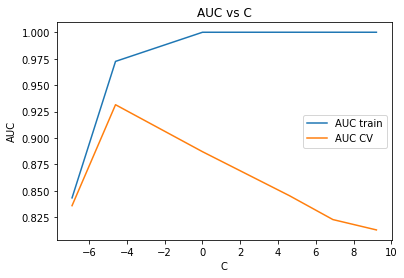

optimal lambda :  100.0
optimal c :  0.01


In [0]:
plt.plot(C, auc_train, label='AUC train')
plt.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('optimal lambda : ',1/optimal_c)
print('optimal c : ',optimal_c)

In [0]:
from sklearn.metrics  import roc_curve

model=LogisticRegression(penalty='l1', C=optimal_c, solver='liblinear')
model.fit(X_train_bow,y_train)
pred=model.predict_proba(X_test_bow)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred)
pred1=model.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,thresholds2=roc_curve(y_train,pred1)

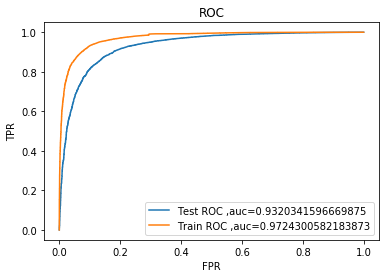

In [0]:
plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

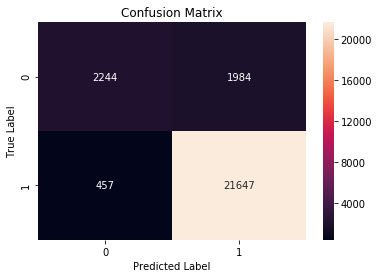

In [0]:
from sklearn.metrics  import  confusion_matrix
pred=model.predict(X_test_bow)
con_mat=confusion_matrix(y_test,pred)
class_label = ["0", "1"]
df = pd.DataFrame(con_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
model=LogisticRegression(penalty='l1',C=optimal_c,solver='liblinear')
model.fit(X_train_bow,y_train)
weight=model.coef_
#Sparsity of vector weight=no of zero in weight vector
print('No of non zero element in weight vector(BOW(l1) =>Imp Features) : ',np.count_nonzero(weight))

No of non zero element in weight vector(BOW(l1) =>Imp Features) :  2933


In [0]:
print(weight.shape)

(1, 39218)


## Logistic Regression BOW (L2 Regularization)

In [0]:

C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for i in C:
    model=LogisticRegression(penalty='l2',C=i)
    model.fit(X_train_bow,y_train)
    pred=model.predict_proba(X_cv_bow)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=model.predict_proba(X_train_bow)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))

In [0]:
import math
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm





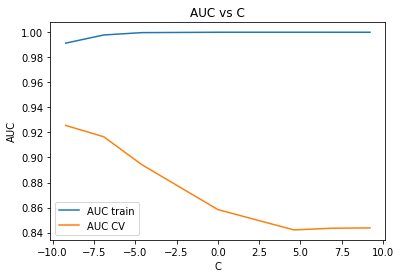

optimal lambda :  10000.0
optimal c :  0.0001


In [0]:
plt.plot(C, auc_train, label='AUC train')
plt.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('optimal lambda : ',1/optimal_c)
print('optimal c : ',optimal_c)

In [0]:
from sklearn.metrics  import roc_curve

model=LogisticRegression(penalty='l2', C=optimal_c)
model.fit(X_train_bow,y_train)
pred=model.predict_proba(X_test_bow)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred)
pred1=model.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,thresholds2=roc_curve(y_train,pred1)

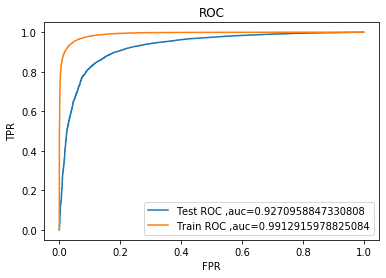

In [0]:
plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

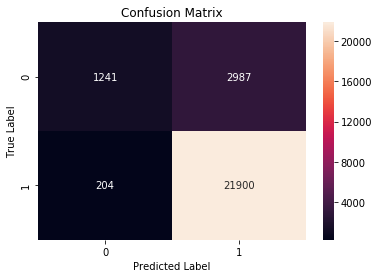

In [0]:
from sklearn.metrics  import  confusion_matrix
pred=model.predict(X_test_bow)
con_mat=confusion_matrix(y_test,pred)
class_label = ["0", "1"]
df = pd.DataFrame(con_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Feature Importance in BOW

In [0]:
weight=model.coef_
print(weight.shape)

features = text_model.get_feature_names()
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(features[i])

(1, 39218)
Top 10 positive features :
great
best
love
delicious
perfect
good
loves
nice
favorite
excellent


In [0]:
print(neg_indx.shape)
print('Top 10 positive features :')
for i in list(neg_indx[0][0:10]):
    print(features[i])

(1, 39218)
Top 10 positive features :
not
disappointed
worst
terrible
horrible
bad
awful
money
disappointing
waste


# Logistic Regression TF-IDF (L1 Regularization)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

X=preprocessed_reviews
y=np.array(final_data['Score'])

tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10)

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)

X_train_tf_idf=tf_idf.fit_transform(X_train)
X_cv_tf_idf=tf_idf.transform(X_cv)
X_test_tf_idf=tf_idf.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_tf_idf = scalar.fit_transform(X_train_tf_idf)
X_test_tf_idf= scalar.transform(X_test_tf_idf)
X_cv_tf_idf=scalar.transform(X_cv_tf_idf)

auc_cv=[]
auc_train=[]

C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda

for i in C:
    model=LogisticRegression(penalty='l1', C=i, solver='liblinear')
    model.fit(X_train_tf_idf, y_train)
    pred = model.predict_proba(X_cv_tf_idf)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=model.predict_proba(X_train_tf_idf)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))

In [0]:
import math
C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm

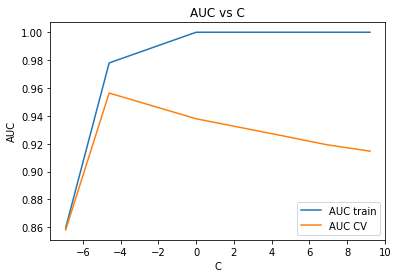

optimal lambda :  100.0
optimal c :  0.01


In [0]:
plt.plot(C, auc_train, label='AUC train')
plt.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('optimal lambda : ',1/optimal_c)
print('optimal c : ',optimal_c)

In [0]:
from sklearn.metrics  import roc_curve

model=LogisticRegression(penalty='l1', C=optimal_c,solver='liblinear')
model.fit(X_train_tf_idf,y_train)
pred=model.predict_proba(X_test_tf_idf)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred)
pred1=model.predict_proba(X_train_tf_idf)[:,1]
fpr2,tpr2,thresholds2=roc_curve(y_train,pred1)

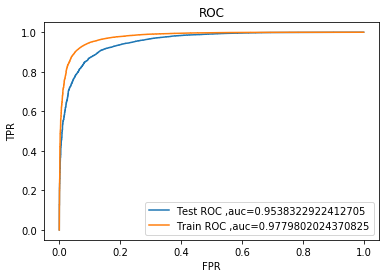

In [0]:
plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

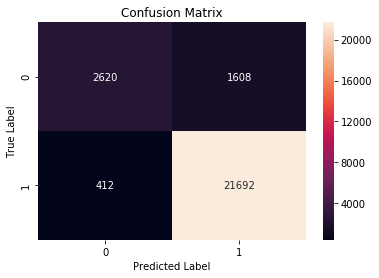

In [0]:
from sklearn.metrics  import  confusion_matrix
pred=model.predict(X_test_tf_idf)
con_mat=confusion_matrix(y_test,pred)
class_label = ["0", "1"]
df = pd.DataFrame(con_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
weight=model.coef_
print(weight.shape)
#Sparsity of vector weight=no of zero in weight vector
print('No of non zero element in weight vector(tf-idf(l1) => Imp Features) : ',np.count_nonzero(weight))

(1, 25538)
No of non zero element in weight vector(tf-idf(l1) => Imp Features) :  2019


# Logistic Regression TF-IDF (L2 Regularization)

In [0]:
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for i in C:
    model=LogisticRegression(penalty='l2',C=i)
    model.fit(X_train_tf_idf,y_train)
    pred=model.predict_proba(X_cv_tf_idf)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=model.predict_proba(X_train_tf_idf)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))

In [0]:
import math
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithmplt.plot(C, auc_train, label='AUC train')


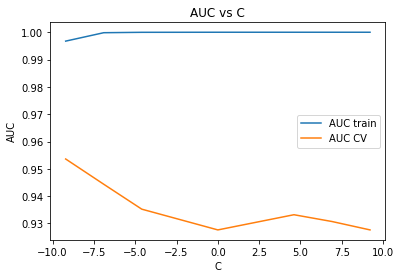

optimal lambda :  10000.0
optimal c :  0.0001


In [0]:
plt.plot(C, auc_train, label='AUC train')
plt.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('optimal lambda : ',1/optimal_c)
print('optimal c : ',optimal_c)

In [0]:
from sklearn.metrics  import roc_curve

model=LogisticRegression(penalty='l2', C=optimal_c)
model.fit(X_train_tf_idf,y_train)
pred=model.predict_proba(X_test_tf_idf)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred)
pred1=model.predict_proba(X_train_tf_idf)[:,1]
fpr2,tpr2,thresholds2=roc_curve(y_train,pred1)

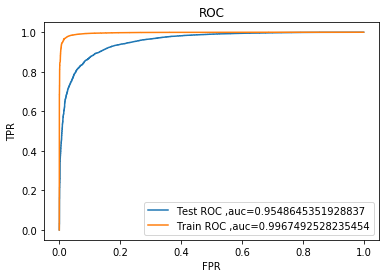

In [0]:
plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

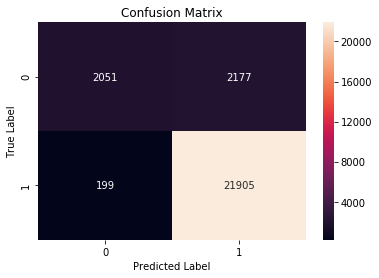

In [0]:
from sklearn.metrics  import  confusion_matrix
pred=model.predict(X_test_tf_idf)
con_mat=confusion_matrix(y_test,pred)
class_label = ["0", "1"]
df = pd.DataFrame(con_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Feature Importance in TF-IDF

In [0]:
weight=model.coef_
print(weight.shape)

features = tf_idf.get_feature_names()
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(features[i])

(1, 25538)
Top 10 positive features :
great
best
delicious
love
good
perfect
loves
nice
excellent
wonderful


In [0]:
print(neg_indx.shape)
print('Top 10 positive features :')
for i in list(neg_indx[0][0:10]):
    print(features[i])

(1, 25538)
Top 10 positive features :
not
disappointed
not buy
worst
not good
not worth
disappointing
terrible
horrible
not recommend


# Logistic Regression on AVG W2V (L1 Regularization)

In [0]:
X=preprocessed_reviews
y=np.array(final_data['Score'])

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)

#word2vec for train
list_of_sentances_train=[]
for sentance in X_train:
    list_of_sentances_train.append(sentance.split())
    
w2v_model=Word2Vec(list_of_sentances_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

sent_vectors_train = []; 
for sent in tqdm(list_of_sentances_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#for cross validation
list_of_sentances_cv=[]
for sentance in X_cv:
    list_of_sentances_cv.append(sentance.split())
    
sent_vectors_cv = []
for sent in tqdm(list_of_sentances_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

#for test data
list_of_sentances_test=[]
for sentance in X_test:
    list_of_sentances_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentances_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


  0%|          | 57/18433 [00:00<00:36, 499.02it/s]

43008
50


100%|██████████| 18433/18433 [00:33<00:00, 554.09it/s]


18433
50


100%|██████████| 26332/26332 [00:47<00:00, 559.23it/s]

26332
50


In [0]:

X_train_avgw2v=sent_vectors_train
X_cv_avgw2v=sent_vectors_cv
X_test_avgw2v=sent_vectors_test

C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda

auc_cv=[]
auc_train=[]

for i in C:
    model=LogisticRegression(penalty='l1', C=i, solver='liblinear')
    model.fit(X_train_avgw2v, y_train)
    pred = model.predict_proba(X_cv_avgw2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=model.predict_proba(X_train_avgw2v)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))

In [0]:
import math
C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithmplt.plot(C, auc_train, label='AUC train')


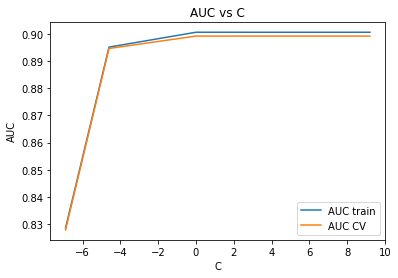

optimal lambda :  0.01
optimal c :  100


In [0]:
plt.plot(C, auc_train, label='AUC train')
plt.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('optimal lambda : ',1/optimal_c)
print('optimal c : ',optimal_c)

In [0]:
from sklearn.metrics  import roc_curve

model=LogisticRegression(penalty='l1', C=optimal_c, solver='liblinear')
model.fit(X_train_avgw2v,y_train)
pred=model.predict_proba(X_test_avgw2v)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred)
pred1=model.predict_proba(X_train_avgw2v)[:,1]
fpr2,tpr2,thresholds2=roc_curve(y_train,pred1)

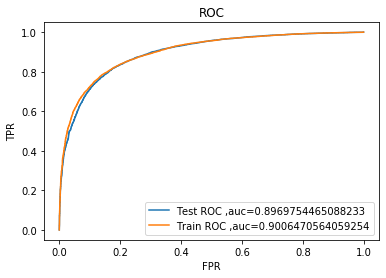

In [0]:
plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

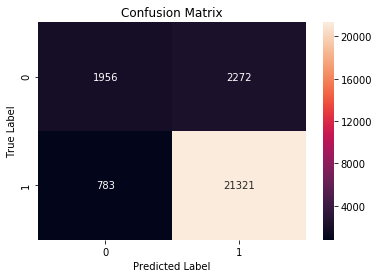

In [0]:
from sklearn.metrics  import  confusion_matrix
pred=model.predict(X_test_avgw2v)
con_mat=confusion_matrix(y_test,pred)
class_label = ["0", "1"]
df = pd.DataFrame(con_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:

weight=model.coef_
print(weight)
print(weight.shape)
#Sparsity of vector weight=no of zero in weight vector
print('No of non zero element in weight vector(AVG-W2v(l1) =>Imp Features) : ',np.count_nonzero(weight))

[[ 0.1836583  -1.55843827 -0.03108143 -0.47288515  0.06696399 -0.15437889
   0.15721756 -0.10621917  0.6588285  -0.00474585  0.69432482  0.90223668
  -0.60973706 -0.37526933  1.10313436 -1.21778119  0.0596768  -1.00698747
   0.25658753  0.74573567 -0.0380696   0.19089133  1.37040159  1.96205955
  -0.52821396  0.02339207  0.81364397 -0.70660808  0.51149638 -1.44253523
  -0.13693296 -0.48628337  1.27032419 -1.17780474  0.43680772  0.53769968
  -0.11142713  0.35318229  1.14583719  0.57124095 -0.15366492 -0.14556961
   0.44006354 -0.41125061  0.16852702 -0.41636221  0.48896104 -1.00776375
   0.74305182 -0.95746451]]
(1, 50)
No of non zero element in weight vector(AVG-W2v(l1) =>Imp Features) :  50


# Logistic Regression on AVG W2V ( L2 Regularization )

In [0]:
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for i in C:
    model=LogisticRegression(penalty='l2',C=i)
    model.fit(X_train_avgw2v,y_train)
    pred=model.predict_proba(X_cv_avgw2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=model.predict_proba(X_train_avgw2v)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))

In [0]:
import math
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithmplt.plot(C, auc_train, label='AUC train')


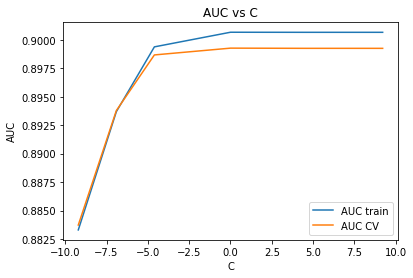

optimal lambda :  1.0
optimal c :  1


In [0]:
plt.plot(C, auc_train, label='AUC train')
plt.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('optimal lambda : ',1/optimal_c)
print('optimal c : ',optimal_c)

In [0]:
from sklearn.metrics  import roc_curve

model=LogisticRegression(penalty='l2', C=optimal_c)
model.fit(X_train_avgw2v,y_train)
pred=model.predict_proba(X_test_avgw2v)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred)
pred1=model.predict_proba(X_train_avgw2v)[:,1]
fpr2,tpr2,thresholds2=roc_curve(y_train,pred1)

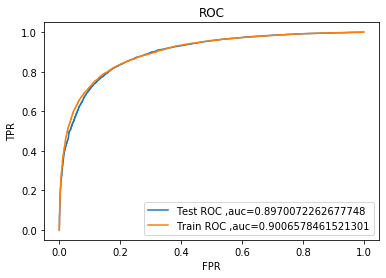

In [0]:

plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

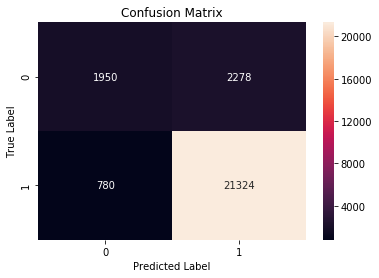

In [0]:
from sklearn.metrics  import  confusion_matrix
pred=model.predict(X_test_avgw2v)
con_mat=confusion_matrix(y_test,pred)
class_label = ["0", "1"]
df = pd.DataFrame(con_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Logistic Regressin on tf-idf Word2Vec (L1 Regularization)

In [0]:
X=preprocessed_reviews
y=np.array(final_data['Score'])


X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)

list_of_sentances_train=[]
for sentance in X_train:
    list_of_sentances_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentances_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf.fit_transform(X_train)


tfidf_feat = tf_idf.get_feature_names() 
dictionary = dict(zip(tf_idf.get_feature_names(), list(tf_idf.idf_)))

#for train data

tfidf_sent_vectors_train = [] 

for sent in tqdm(list_of_sentances_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)


#for cross validation data
list_of_sentances_cv=[]
for sentance in X_cv:
    list_of_sentances_cv.append(sentance.split())
    
tfidf_sent_vectors_cv = []

for sent in tqdm(list_of_sentances_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)


#for test data
list_of_sentances_test=[]
for sentance in X_test:
    list_of_sentances_test.append(sentance.split())
tfidf_sent_vectors_test = []

for sent in tqdm(list_of_sentances_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)


100%|██████████| 26332/26332 [00:59<00:00, 441.94it/s]


In [0]:
from sklearn.metrics import roc_auc_score,roc_curve

X_train_tfiddf_w2v=tfidf_sent_vectors_train
X_cv_tfiddf_w2v=tfidf_sent_vectors_cv
X_test_tfiddf_w2v=tfidf_sent_vectors_test
auc_cv=[]
auc_train=[]
C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda

for i in C:
    model=LogisticRegression(penalty='l1', C=i, solver='liblinear')
    model.fit(X_train_tfiddf_w2v, y_train)
    pred = model.predict_proba(X_cv_tfiddf_w2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=model.predict_proba(X_train_tfiddf_w2v)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))

In [0]:
import math
C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm

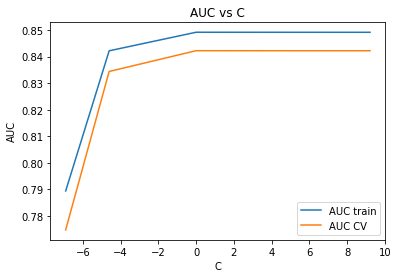

optimal lambda :  1.0
optimal c :  1


In [0]:
plt.plot(C, auc_train, label='AUC train')
plt.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('optimal lambda : ',1/optimal_c)
print('optimal c : ',optimal_c)

In [0]:
from sklearn.metrics  import roc_curve

model=LogisticRegression(penalty='l1', C=optimal_c,solver='liblinear')
model.fit(X_train_tfiddf_w2v,y_train)
pred=model.predict_proba(X_test_tfiddf_w2v)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred)
pred1=model.predict_proba(X_train_tfiddf_w2v)[:,1]
fpr2,tpr2,thresholds2=roc_curve(y_train,pred1)

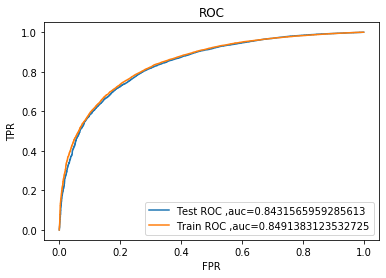

In [0]:
plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

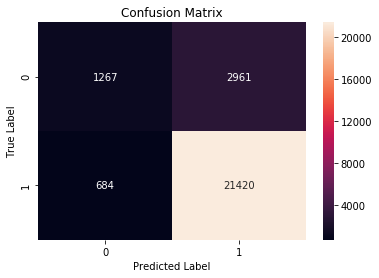

In [0]:
from sklearn.metrics  import  confusion_matrix
pred=model.predict(X_test_tfiddf_w2v)
con_mat=confusion_matrix(y_test,pred)
class_label = ["0", "1"]
df = pd.DataFrame(con_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
weight=model.coef_
print(weight.shape)
#Sparsity of vector weight=no of zero in weight vector
print('No of non zero element in weight vector(tf-idf W2V(l1) => Imp Features) : ',np.count_nonzero(weight))

(1, 50)
No of non zero element in weight vector(tf-idf W2V(l1) => Imp Features) :  49


### Logistic Regressin on tf-idf Word2Vec (L2 Regularization)

In [0]:
auc_cv=[]
auc_train=[]
C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda

for i in C:
    model=LogisticRegression(penalty='l2', C=i)
    model.fit(X_train_tfiddf_w2v, y_train)
    pred = model.predict_proba(X_cv_tfiddf_w2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=model.predict_proba(X_train_tfiddf_w2v)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))

In [0]:
import math
C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithmplt.plot(C, auc_train, label='AUC train')





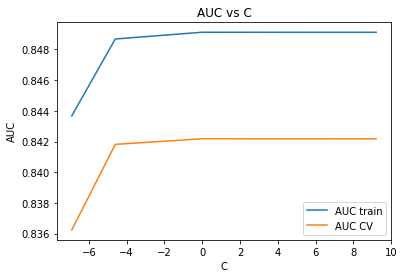

optimal lambda :  1.0
optimal c :  1


In [0]:
plt.plot(C, auc_train, label='AUC train')
plt.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('optimal lambda : ',1/optimal_c)
print('optimal c : ',optimal_c)

In [0]:
from sklearn.metrics  import roc_curve

model=LogisticRegression(penalty='l2', C=optimal_c)
model.fit(X_train_tfiddf_w2v,y_train)
pred=model.predict_proba(X_test_tfiddf_w2v)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred)
pred1=model.predict_proba(X_train_tfiddf_w2v)[:,1]
fpr2,tpr2,thresholds2=roc_curve(y_train,pred1)

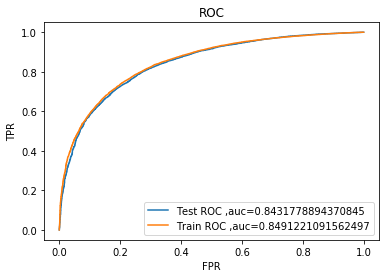

In [0]:
plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

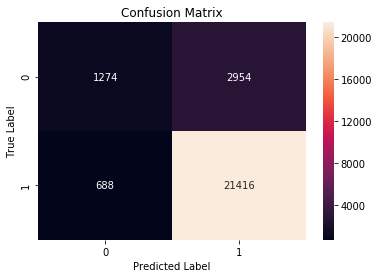

In [0]:
from sklearn.metrics  import  confusion_matrix
pred=model.predict(X_test_tfiddf_w2v)
con_mat=confusion_matrix(y_test,pred)
class_label = ["0", "1"]
df = pd.DataFrame(con_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#Feature Engineering

In [0]:
#Feature Engineering 
#Adding preprocessed summary and review length to preprocessed summary
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]+=' '+preprocessed_summary[i]

preprocessed_reviews[100]

'frenchbull given nylabone chew since weeks old safe strong bite not break large pieces could choke dinosaur chew perfect many places hold bite dylabone product buy frenchbull dog loves nylabones'

In [0]:
X=preprocessed_reviews
y=np.array(final_data['Score'])

tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10)

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)

X_train_tf_idf=tf_idf.fit_transform(X_train)
X_cv_tf_idf=tf_idf.transform(X_cv)
X_test_tf_idf=tf_idf.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_tf_tf_idf = scalar.fit_transform(X_train_tf_idf)
X_test_tf_tf_idf= scalar.transform(X_test_tf_idf)
X_cv_tf_tf_idf=scalar.transform(X_cv_tf_idf)


In [0]:

auc_train=[]
auc_cv=[]
C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda

for i in C:
    model=LogisticRegression(penalty='l1', C=i, solver='liblinear')
    model.fit(X_train_tf_idf, y_train)
    pred = model.predict_proba(X_cv_tf_idf)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=model.predict_proba(X_train_tf_idf)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))

In [0]:
import math
C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithmplt.plot(C, auc_train, label='AUC train')





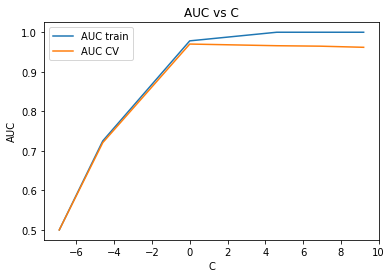

optimal lambda :  1.0
optimal c :  1


In [0]:
plt.plot(C, auc_train, label='AUC train')
plt.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
plt.show()

print('optimal lambda : ',1/optimal_c)
print('optimal c : ',optimal_c)

In [0]:
from sklearn.metrics  import roc_curve

model=LogisticRegression(penalty='l1', C=optimal_c,solver='liblinear')
model.fit(X_train_tf_idf,y_train)
pred=model.predict_proba(X_test_tf_idf)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, pred)
pred1=model.predict_proba(X_train_tf_idf)[:,1]
fpr2,tpr2,thresholds2=roc_curve(y_train,pred1)

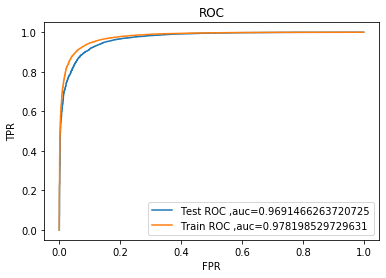

In [0]:
plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,pred)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred1)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

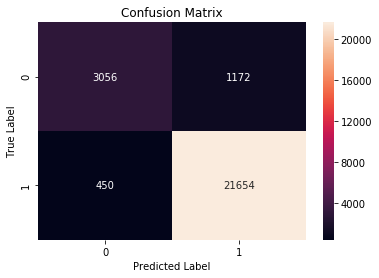

In [0]:
from sklearn.metrics  import  confusion_matrix
pred=model.predict(X_test_tf_idf)
con_mat=confusion_matrix(y_test,pred)
class_label = ["0", "1"]
df = pd.DataFrame(con_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Conclusions

In [1]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Regularization", "Feature engineering", "Hyperameter(lambda)", "AUC"]
x.add_row(["BOW","l1","Not featured",100,0.9320])
x.add_row(["BOW","l2","Not featured",10000,0.9270])
x.add_row(["TFIDF","l1","Not featured",100,0.9538])
x.add_row(["TFIDF","l2","Not featured",10000,0.9548])
x.add_row(["Avg W2v","l1","Not featured",100,0.8969])
x.add_row(["Avg W2v","l2","Not featured",1,0.8970])
x.add_row(["TFIDF Avg W2v","l1","Not featured",1,0.8431])
x.add_row(["TFIDF Avg W2v","l2","Not featured",1,0.8431])

x.add_row(["TFIDF","l1","featured",1,0.9691])

print(x)

+---------------+----------------+---------------------+---------------------+--------+
|   Vectorizer  | Regularization | Feature engineering | Hyperameter(lambda) |  AUC   |
+---------------+----------------+---------------------+---------------------+--------+
|      BOW      |       l1       |     Not featured    |         100         | 0.932  |
|      BOW      |       l2       |     Not featured    |        10000        | 0.927  |
|     TFIDF     |       l1       |     Not featured    |         100         | 0.9538 |
|     TFIDF     |       l2       |     Not featured    |        10000        | 0.9548 |
|    Avg W2v    |       l1       |     Not featured    |         100         | 0.8969 |
|    Avg W2v    |       l2       |     Not featured    |          1          | 0.897  |
| TFIDF Avg W2v |       l1       |     Not featured    |          1          | 0.8431 |
| TFIDF Avg W2v |       l2       |     Not featured    |          1          | 0.8431 |
|     TFIDF     |       l1      